In [1]:
import quandl, math
import numpy as np
import pandas as pd
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import datetime

/Users/bcbarsness/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
style.use('ggplot')

In [14]:
df = quandl.get("WIKI/GOOGL")
df = df[['Adj. Open',  'Adj. High',  'Adj. Low',  'Adj. Close', 'Adj. Volume']]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0
df.shape

(3260, 7)

In [15]:
df.tail()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,HL_PCT,PCT_change
Date,,,,,,,
2017-07-25,970.70,976.7300,963.800,969.03,5793414.0,1.334324,-0.172041
2017-07-26,972.78,973.9500,960.230,965.31,2166225.0,1.421305,-0.767902
2017-07-27,969.18,969.5200,937.060,952.51,3685905.0,3.407838,-1.720011
2017-07-28,947.99,961.7900,945.310,958.33,1795477.0,1.719658,1.090729
2017-07-31,960.00,961.1925,941.725,945.50,2268160.0,2.058964,-1.510417


In [16]:
# Are there an NaN in the dataset?
df.isnull().values.any()

False

In [17]:
# How many NaN exist in the dataset?
df.isnull().sum().sum()

0

In [25]:
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]
forecast_col = 'Adj. Close'
#df.fillna(value=-99999, inplace=True)
forecast_out = int(math.ceil(0.01 * len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)



In [29]:
df.head(34)

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label
Date,,,,,
2004-08-19,50.322842,8.072956,0.324968,44659000.0,68.752232
2004-08-20,54.322689,7.921706,7.227007,22834300.0,69.639972
2004-08-23,54.869377,4.049360,-1.227880,18256100.0,69.078238
2004-08-24,52.597363,7.657099,-5.726357,15247300.0,67.839414
2004-08-25,53.164113,3.886792,1.183658,9188600.0,68.912727
2004-08-26,54.122070,3.048837,2.820391,7094800.0,70.668146
2004-08-27,53.239345,2.760245,-1.803885,6211700.0,71.219849
2004-08-30,51.162935,3.411430,-3.106003,5196700.0,72.278116
2004-08-31,51.343492,1.514115,0.048866,4917800.0,74.810934


In [39]:
X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
X


array([[-1.48311145,  4.20647602,  0.23047825,  4.3847478 ],
       [-1.46497796,  4.09908995,  4.77664553,  1.76521024],
       [-1.46249953,  1.34974959, -0.79233605,  1.21570593],
       ..., 
       [ 2.6868298 ,  2.28992426, -2.300564  , -0.54173519],
       [ 2.64915605,  0.77823584,  0.22872437, -0.47533425],
       [ 2.68855255, -0.36206549, -0.08792103, -0.73635876]])

In [38]:
df.isnull().sum().sum()

33

In [40]:
df.dropna(inplace=True)
df.isnull().sum().sum()

0

In [41]:
y = np.array(df['label'])

In [42]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)

In [43]:
accuracy

0.97251212196264925

In [54]:
forecast_set = clf.predict(X_lately)
df['Forecast'] = np.nan
forecast_set

array([  979.86559702,   971.67600429,   971.14221409,   988.02360334,
         981.77034315,   991.52214885,   990.01586653,   998.77362127,
         983.76518702,   959.77208832,   971.71815298,   949.06318989,
         941.87651886,   931.34829732,   944.04181171,   939.68381724,
         953.02046738,   963.69956881,   966.43516801,   980.23792888,
         981.25944262,   990.22968335,   988.6191221 ,   998.93415806,
        1005.92177848,  1004.84191301,  1006.73083891,  1010.29982392,
         980.59652316,   977.74579176,   962.60487371,   970.38077664,
         957.29235354])

In [55]:
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]


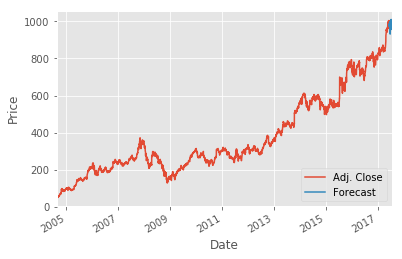

In [56]:
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()